<a href="https://colab.research.google.com/github/LBncl/AmazonMLInterviewQuestion/blob/main/NAFLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAFLD PROJECT

## Imports

In [205]:
# Imports
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Cleaning

In [206]:
# Read in data
df = pd.read_excel('master_with_nordic_and_multiBM.xlsx')

# Check if dataFrame is empty
if df.empty:
    print('DataFrame is empty!')

In [207]:
# Subset data frame
main_df = df.filter(items=['CPH_EV_AGE_CALC', 'TBL.PATIENT.INFO..PI_BL_GENDER', 'CPH_EV_CI_BMI_CALC', 
                         'TBL.ALL.EVENTS..AE_SF_ALCO_XS', 'insulin_resistance', 'hypertensive', 'waist_to_hip_ratio',
                         'idf_metabolic_syndrome', 'eGFR', 'dyslipidaemia', 'fibroscan_stiffness_reliable',
                         'TBL.ALL.EVENTS..AE_BR_ALT_iuL',
                         'TBL.ALL.EVENTS..AE_BR_AST_iuL', 'TBL.ALL.EVENTS..AE_BR_GGT_iuL',
                         'TBL.ALL.EVENTS..AE_BR_FERR_ugL',
                         'TBL.ALL.EVENTS..AE_BR_PLT_109L', 'TBL.ALL.EVENTS..AE_BR_CREAT_umolL_CALC',
                         'TBL.ALL.EVENTS..AE_BR_STG_mmolL_CALC',
                         'TBL.ALL.EVENTS..AE_BR_ALBU_gL_CALC', 'TBL.ALL.EVENTS..AE_BR_BILI_umolL_CALC',
                         'TBL.ALL.EVENTS..AE_BR_IGA',
                         'TBL.ALL.EVENTS..AE_CD_OSA', 'LIT_NB_CK18_M30', 'LIT_NB_CK18_M65', 'LIT_NB_PRO_C3', 'LIT_NB_PRO_C6',
                          'LIT_NB_ELF', 'FIB4', 'NFS', 'APRI', 'ADAPT', 'FIBC3', 'ABC3D', 'BARD', 'AST_ALT_Ratio', 'response_4'])

In [208]:
main_df.describe()

,CPH_EV_AGE_CALC,TBL.PATIENT.INFO..PI_BL_GENDER,CPH_EV_CI_BMI_CALC,TBL.ALL.EVENTS..AE_SF_ALCO_XS,insulin_resistance,hypertensive,waist_to_hip_ratio,idf_metabolic_syndrome,eGFR,dyslipidaemia,...,LIT_NB_ELF,FIB4,NFS,APRI,ADAPT,FIBC3,ABC3D,BARD,AST_ALT_Ratio,response_4
count,13586.000000,14201.000000,12165.000000,11522.000000,14236.000000,14236.000000,5820.000000,14236.000000,9534.000000,12133.000000,...,885.000000,11719.000000,11622.000000,11905.000000,817.000000,793.000000,10843.000000,11265.000000,12440.000000,8912.000000
mean,53.472030,0.474192,33.182239,0.024128,0.440573,0.583521,0.982904,0.388101,87.310360,0.555263,...,9.099040,1.824640,3.910500,0.514922,5.932189,-0.826637,2.502813,2.138038,0.853398,0.324057
std,13.107971,0.499351,6.284331,0.153452,0.496473,0.492992,0.092241,0.487335,23.660890,0.496957,...,2.143533,1.108360,1.040029,0.441854,2.456450,1.995090,1.523494,1.266593,0.384123,0.468048
min,18.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.607955,0.000000,10.544338,0.000000,...,0.000000,0.189169,1.113721,0.055332,0.000000,-6.116460,0.000000,0.000000,0.066298,0.000000
25%,45.000000,0.000000,28.400000,0.000000,0.000000,0.000000,0.926296,0.000000,72.212414,0.000000,...,8.490000,1.086985,3.114010,0.248918,4.552078,-2.290440,1.000000,1.000000,0.600000,0.000000
50%,55.000000,0.000000,32.209024,0.000000,0.000000,1.000000,0.981337,0.000000,85.135980,1.000000,...,9.370000,1.555336,3.934300,0.381737,5.843019,-0.835500,2.000000,2.000000,0.773585,0.000000
75%,63.000000,1.000000,37.148444,0.000000,1.000000,1.000000,1.033755,1.000000,100.465008,1.000000,...,10.150000,2.279568,4.726000,0.620370,7.091320,0.540100,4.000000,3.000000,1.000000,1.000000
max,80.000000,1.000000,50.000000,1.000000,1.000000,1.000000,2.051724,1.000000,319.657371,1.000000,...,13.010000,13.027388,6.641940,10.267857,17.221921,7.775900,6.000000,4.000000,6.615385,1.000000


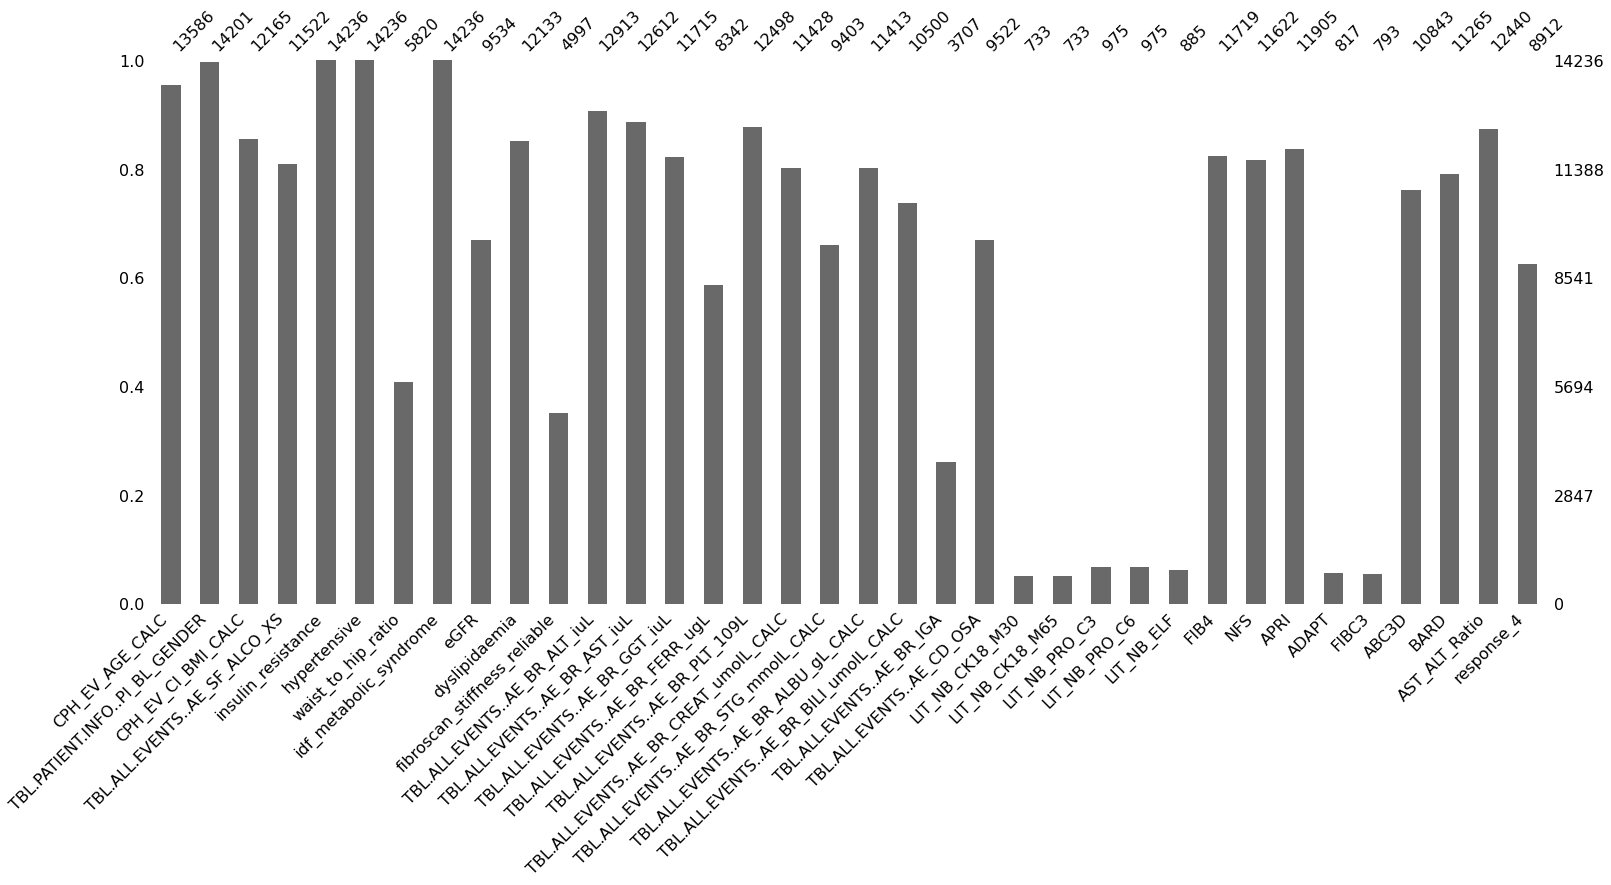

In [175]:
msno.bar(main_df)

In [209]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Convert required variables to boolean and normlaise the remaining variables
features_raw = main_df.iloc[:, 0:35]

# Loop to check for boolean columns
for column in features_raw:
  if features_raw[column].max() == 1:
    features_raw[column] = features_raw[column].astype(bool)

cols_normalise = features_raw.select_dtypes(include=[np.float64])

# scaler
scaler = MinMaxScaler()
features_raw[cols_normalise.columns] = scaler.fit_transform(cols_normalise)

In [181]:
features_raw

,CPH_EV_AGE_CALC,TBL.PATIENT.INFO..PI_BL_GENDER,CPH_EV_CI_BMI_CALC,TBL.ALL.EVENTS..AE_SF_ALCO_XS,insulin_resistance,hypertensive,waist_to_hip_ratio,idf_metabolic_syndrome,eGFR,dyslipidaemia,...,LIT_NB_PRO_C6,LIT_NB_ELF,FIB4,NFS,APRI,ADAPT,FIBC3,ABC3D,BARD,AST_ALT_Ratio
0,0.483871,True,0.688333,False,True,False,NaN,False,0.372730,False,...,NaN,NaN,0.046102,0.712414,0.020094,NaN,NaN,0.500000,1.00,0.139019
1,0.516129,True,0.639333,False,True,False,0.256376,True,0.426672,False,...,NaN,NaN,0.055215,0.700804,0.023010,NaN,NaN,0.500000,1.00,0.167198
2,0.548387,True,0.683000,False,True,False,0.256264,True,0.464912,False,...,NaN,NaN,0.059302,0.736465,0.022975,NaN,NaN,0.666667,1.00,0.156043
3,0.483871,False,0.165333,False,True,True,0.228253,False,NaN,True,...,NaN,NaN,0.299008,0.445626,0.193066,NaN,NaN,0.500000,0.25,0.084914
4,0.532258,False,0.222333,False,True,True,NaN,False,NaN,True,...,NaN,NaN,0.239338,0.494781,0.153369,NaN,NaN,0.666667,0.75,0.120756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14231,0.661290,True,0.386333,False,True,True,NaN,False,NaN,True,...,NaN,NaN,NaN,0.631983,NaN,NaN,NaN,0.666667,NaN,NaN
14232,0.354839,True,0.393333,False,False,False,0.229013,False,NaN,True,...,NaN,NaN,NaN,0.303982,NaN,NaN,NaN,NaN,NaN,NaN
14233,0.677419,True,0.356667,False,False,False,NaN,True,0.601116,True,...,NaN,NaN,0.103404,0.419137,0.046431,NaN,NaN,0.333333,0.75,0.165618
14234,0.677419,True,0.443667,False,True,True,NaN,True,NaN,True,...,NaN,NaN,NaN,0.667922,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
# Filter to only select basline event types
features_raw['CPH_EV_EVENT_TYPE'] = df['CPH_EV_EVENT_TYPE']
is_Baseline = features_raw['CPH_EV_EVENT_TYPE'] == 'Baseline'
features_baseline = features_raw[is_Baseline]
features_baseline = features_baseline.iloc[: , :-1]
features_baseline = features_baseline.reset_index()
features_baseline = features_baseline.iloc[: , 1:]

In [183]:
features_baseline

,CPH_EV_AGE_CALC,TBL.PATIENT.INFO..PI_BL_GENDER,CPH_EV_CI_BMI_CALC,TBL.ALL.EVENTS..AE_SF_ALCO_XS,insulin_resistance,hypertensive,waist_to_hip_ratio,idf_metabolic_syndrome,eGFR,dyslipidaemia,...,LIT_NB_PRO_C6,LIT_NB_ELF,FIB4,NFS,APRI,ADAPT,FIBC3,ABC3D,BARD,AST_ALT_Ratio
0,0.483871,True,0.688333,False,True,False,NaN,False,0.372730,False,...,NaN,NaN,0.046102,0.712414,0.020094,NaN,NaN,0.500000,1.00,0.139019
1,0.483871,False,0.165333,False,True,True,0.228253,False,NaN,True,...,NaN,NaN,0.299008,0.445626,0.193066,NaN,NaN,0.500000,0.25,0.084914
2,0.451613,True,0.490333,True,False,False,NaN,False,0.206727,False,...,NaN,NaN,0.049002,0.393620,0.012570,NaN,NaN,0.166667,0.25,0.103165
3,0.451613,False,0.681333,True,False,False,NaN,True,0.271090,True,...,NaN,NaN,0.063383,0.491051,0.018272,NaN,NaN,0.166667,0.25,0.101301
4,0.467742,True,0.458333,True,False,True,NaN,True,0.266578,True,...,NaN,NaN,0.035208,0.383990,0.012686,NaN,NaN,0.166667,0.75,0.184984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,0.661290,True,0.386333,False,True,True,NaN,False,NaN,True,...,NaN,NaN,NaN,0.631983,NaN,NaN,NaN,0.666667,NaN,NaN
9284,0.354839,True,0.393333,False,False,False,0.229013,False,NaN,True,...,NaN,NaN,NaN,0.303982,NaN,NaN,NaN,NaN,NaN,NaN
9285,0.677419,True,0.356667,False,False,False,NaN,True,0.601116,True,...,NaN,NaN,0.103404,0.419137,0.046431,NaN,NaN,0.333333,0.75,0.165618
9286,0.677419,True,0.443667,False,True,True,NaN,True,NaN,True,...,NaN,NaN,NaN,0.667922,NaN,NaN,NaN,NaN,NaN,NaN


## Data Imputation Strategies

In [211]:
# Imports for imputation functions
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

In [185]:
# Single imputation with mean to replace not a number (NaNs)
def nan2mean(fdf):
    cols = list(fdf.columns)
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [186]:
# Single imputation with median to replace not a number (NaNs)
def nan2median(fdf):
    cols = list(fdf.columns)
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [187]:
# Single imputation with most_frequent to replace not a number (NaNs)
def nan2most_frequent(fdf):
    cols = list(fdf.columns)
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [188]:
# Multiple Imputation by chained equation linear regression
def nan2mice(fdf):
    cols = list(fdf.columns)
    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=50, imputation_order='roman',random_state=0)
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [189]:
# Imputation by K neasrest neighbours
def nan2knn(fdf):
    cols = list(fdf.columns)
    imp = KNNImputer(n_neighbors=2, weights="distance")
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

## Model evaluation

In [192]:
# Create new imputed datasets
featuresKNN = nan2knn(features_baseline)
featuresMean = nan2mean(features_baseline)
featuresMedian = nan2median(features_baseline)
featuresMICE = nan2mice(features_baseline)
featuresMostFrq = nan2most_frequent(features_baseline)
featuresMostFrq = featuresMostFrq.apply(pd.to_numeric)

# Create list of all imputation strategies
imputed_features = [featuresKNN,featuresMean,featuresMedian,featuresMICE,featuresMostFrq]
imputed_features_names = ['featuresKNN','featuresMean','featuresMedian','featuresMICE','featuresMostFrq']

Text(0.5, 0, 'CPH_EV_CI_BMI_CALC')

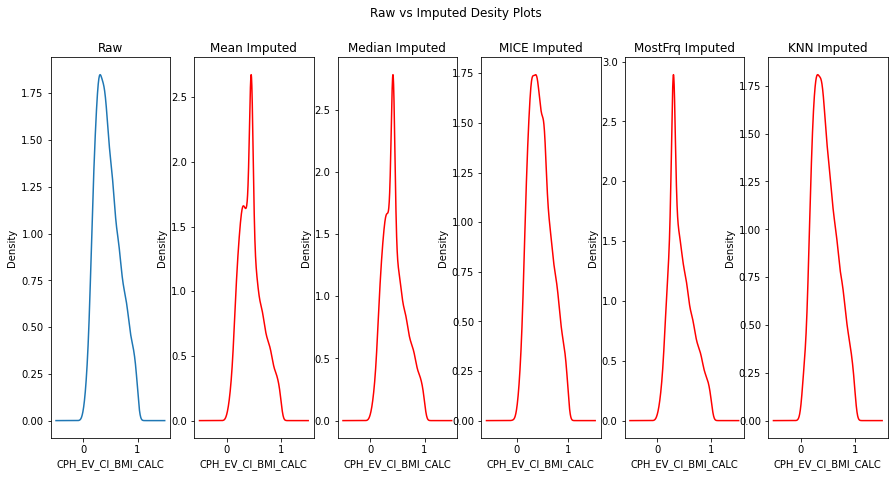

In [204]:
column_name = "CPH_EV_CI_BMI_CALC"

d = {'raw': features_baseline[column_name], 
     'KNN Imputation': featuresKNN[column_name],
     'Mean Imputation': featuresMean[column_name],
     'Median Imputation': featuresMedian[column_name],
     'MICE Imputation': featuresMICE[column_name],
     'MostFrq Imputation': featuresMostFrq[column_name]}
fdata = pd.DataFrame(data=d)

# calling density() to make multiple density plot 
fig, axes = plt.subplots(1, 6)
fig.suptitle('Raw vs Imputed Desity Plots')
fdata['raw'].plot.density(ax=axes[0], figsize = (15, 7))
fdata['Mean Imputation'].plot.density(ax=axes[1], figsize = (15, 7), color='red')
fdata['Median Imputation'].plot.density(ax=axes[2], figsize = (15, 7), color='red')
fdata['MICE Imputation'].plot.density(ax=axes[3], figsize = (15, 7), color='red')
fdata['MostFrq Imputation'].plot.density(ax=axes[4], figsize = (15, 7), color='red')
fdata['KNN Imputation'].plot.density(ax=axes[5], figsize = (15, 7), color='red')

axes[0].set_title('Raw')
axes[1].set_title('Mean Imputed')
axes[2].set_title('Median Imputed')
axes[3].set_title('MICE Imputed')
axes[4].set_title('MostFrq Imputed')
axes[5].set_title('KNN Imputed')

axes[0].set_xlabel(column_name)
axes[1].set_xlabel(column_name)
axes[2].set_xlabel(column_name)
axes[3].set_xlabel(column_name)
axes[4].set_xlabel(column_name)
axes[5].set_xlabel(column_name)

In [215]:
# Pull response from data frame with only baseline observations
y = main_df["response_4"]
response = pd.DataFrame({'y':y, 'Baseline':df['CPH_EV_EVENT_TYPE']})
is_Baseline = response['Baseline'] == 'Baseline'
response = response[is_Baseline]
response = response['y']

# Add response variable to all imputed datasets and remove observations with NaN responses
for i in range(len(imputed_features)):
  df = imputed_features[i]
  df['response'] = response
  df = df.dropna(inplace=True)

# Feature Selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (5318, 36)
    Loaded train data. Shape = (5318, 36)
    Some column names had special characters which were removed...
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
###################################################

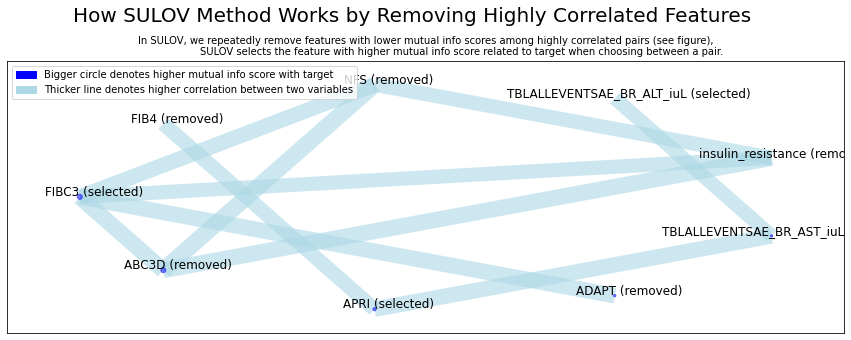

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 29
Final list of selected vars after SULOV = 29
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 29 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 29 variables...
            Time taken for regular XGBoost feature selection = 6 seconds
        using 23 variables...
            Time taken for regular XGBoost feature selection = 10 seconds
        using 17 variables...
            Time taken for regular XGBoost feature selectio

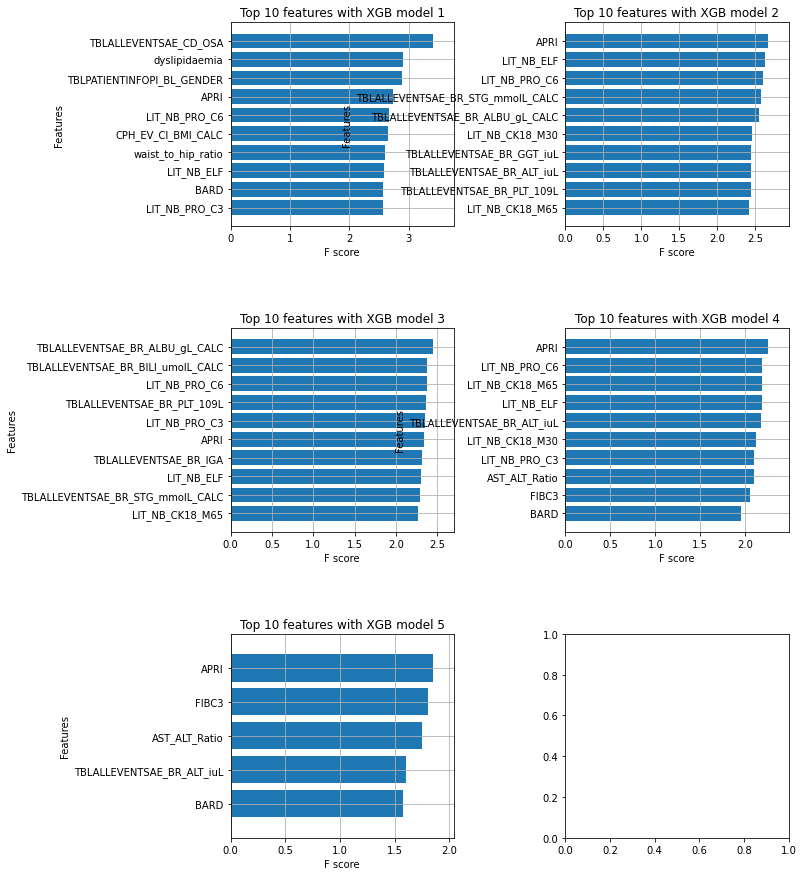

            Total time taken for XGBoost feature selection = 22 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 21 important features:
['TBLALLEVENTSAE_CD_OSA', 'dyslipidaemia', 'TBLPATIENTINFOPI_BL_GENDER', 'APRI', 'LIT_NB_PRO_C6', 'CPH_EV_CI_BMI_CALC', 'waist_to_hip_ratio', 'LIT_NB_ELF', 'BARD', 'LIT_NB_PRO_C3', 'TBLALLEVENTSAE_BR_STG_mmolL_CALC', 'TBLALLEVENTSAE_BR_ALBU_gL_CALC', 'LIT_NB_CK18_M30', 'TBLALLEVENTSAE_BR_GGT_iuL', 'TBLALLEVENTSAE_BR_ALT_iuL', 'TBLALLEVENTSAE_BR_PLT_109L', 'LIT_NB_CK18_M65', 'TBLALLEVENTSAE_BR_BILI_umolL_CALC', 'TBLALLEVENTSAE_BR_IGA', 'AST_ALT_Ratio', 'FIBC3']

    Time taken for feature selection = 23 seconds
Returning 2 dataframes: dataname and test_data with 21 important features.


In [216]:
# automatic feature selection by using featurewiz package
from featurewiz import featurewiz
target = 'response'

features_selected, train = featurewiz(featuresKNN, target, corr_limit=0.7, verbose=2, sep=",", header=0,test_data="", feature_engg="", category_encoders="")

In [217]:
from sklearn.model_selection import train_test_split

# function to generate test/train split
def train_test (fdf):
  # Split data into test and trian
  X_train, X_test, y_train, y_test = train_test_split(fdf.iloc[:, 0:len(features_selected)], fdf.iloc[: , -1], test_size=0.30, random_state=0)
  return X_train, X_test, y_train, y_test

In [218]:
# Filter all data frames based upon best features
featuresKNN = featuresKNN[features_selected]
featuresMean = featuresMean[features_selected]
featuresMedian = featuresMedian[features_selected]
featuresMICE = featuresMICE[features_selected]
featuresMostFrq = featuresMostFrq[features_selected]

imputed_features = [featuresKNN,featuresMean,featuresMedian,featuresMICE,featuresMostFrq]

# Add response variable to all imputed datasets
for i in range(len(imputed_features)):
  df = imputed_features[i]
  df['response'] = response

In [219]:
featuresKNN

,TBL.ALL.EVENTS..AE_CD_OSA,dyslipidaemia,TBL.PATIENT.INFO..PI_BL_GENDER,APRI,LIT_NB_PRO_C6,CPH_EV_CI_BMI_CALC,waist_to_hip_ratio,LIT_NB_ELF,BARD,LIT_NB_PRO_C3,...,LIT_NB_CK18_M30,TBL.ALL.EVENTS..AE_BR_GGT_iuL,TBL.ALL.EVENTS..AE_BR_ALT_iuL,TBL.ALL.EVENTS..AE_BR_PLT_109L,LIT_NB_CK18_M65,TBL.ALL.EVENTS..AE_BR_BILI_umolL_CALC,TBL.ALL.EVENTS..AE_BR_IGA,AST_ALT_Ratio,FIBC3,response
0,0.0,0.0,1.0,0.020094,0.040896,0.688333,0.195283,0.708297,1.000000,0.096369,...,0.026317,0.276212,0.138075,0.544753,0.039106,0.129032,0.005481,0.139019,0.501314,0.0
3,1.0,1.0,0.0,0.018272,0.024540,0.681333,0.358340,0.743319,0.250000,0.180034,...,0.059754,0.015784,0.112971,0.353395,0.026865,0.161290,0.003126,0.101301,0.340707,1.0
6,1.0,1.0,1.0,0.029187,0.030229,0.776667,0.219726,0.770365,1.000000,0.142943,...,0.122280,0.006764,0.092050,0.217593,0.119720,0.000000,0.002083,0.118711,0.558782,0.0
7,1.0,1.0,0.0,0.009395,0.035916,0.802667,0.371067,0.723477,0.500000,0.142322,...,0.072081,0.052988,0.079498,0.407407,0.017606,0.193548,0.003671,0.089917,0.465329,1.0
8,1.0,0.0,1.0,0.011389,0.027342,0.826333,0.202268,0.634621,0.750000,0.122919,...,0.049361,0.005637,0.046025,0.439815,0.008498,0.193548,0.003242,0.157112,0.171550,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9281,0.0,1.0,0.0,0.029511,0.036912,0.320000,0.291914,0.727236,0.779518,0.113457,...,0.097031,0.011372,0.136986,0.280864,0.030982,0.147066,0.003756,0.112592,0.416200,1.0
9282,1.0,1.0,0.0,0.023308,0.044589,0.336667,0.498991,0.766536,1.000000,0.138241,...,0.028739,0.016911,0.071130,0.225309,0.012877,0.131848,0.001954,0.119949,0.509547,0.0
9285,0.0,1.0,1.0,0.046431,0.053201,0.356667,0.238854,0.696876,0.750000,0.156071,...,0.504131,0.068771,0.179916,0.367284,0.121924,0.113677,0.003422,0.165618,0.279051,1.0
9286,0.0,1.0,1.0,0.064149,0.034904,0.443667,0.297602,0.740200,0.763655,0.173739,...,0.117995,0.185446,0.205777,0.175017,0.194913,0.062526,0.168453,0.113835,0.336223,1.0


### Logistic Regression

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Logistic Regression model
# Implement the model
logreg = LogisticRegression()

# hyperparameters, penalty values chosen to work with all solvers
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

for i in range(len(imputed_features)):
  df = imputed_features[i]
  grid_result = grid_search.fit(df.iloc[:, 0:len(features_selected)], df.iloc[: , -1])

  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_), imputed_features_names[i])

Best: 0.701392 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'} featuresKNN
Best: 0.701392 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'} featuresMean
Best: 0.701580 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} featuresMedian
Best: 0.701392 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'} featuresMICE
Best: 0.701517 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} featuresMostFrq


### SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



### XGBoost 

In [221]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Implement the model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

for i in range(len(imputed_features)):
  df = imputed_features[i]
  X_train, X_test, y_train, y_test = train_test(df)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(accuracy)



0.6428571428571429
0.6484962406015038
0.6516290726817042
0.6428571428571429
0.6578947368421053


In [161]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
features_baseline['y'] = response
filtered_df = features_baseline[features_baseline['y'].notna()]
X_train, X_test, y_train, y_test = train_test(filtered_df)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5733916302311055


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def model_RF(fdf, response):
  # Pull the correct resposne variable from the dataframe
  y = main_df[response]
  # Remove all rows with missing observations
  X = fdf
  X['y'] = y
  X = fdf.dropna()
  # Split data into test and trian
  X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 0:35], X.iloc[: , -1], test_size=0.20, random_state=0)
  # Implement the model
  regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  #use model to predict probability that given y value is 1
  y_pred_proba = regressor.predict_proba(X_test)[::,1]

  #calculate AUC of model
  auc = metrics.roc_auc_score(y_test, y_pred_proba)

  #print AUC score
  print(auc)

  # Calculate F-score
  report = classification_report(y_test, y_pred)
  print(report)

  return y_pred

## Model Imports

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

# Pipeline

## Imputation and Target Variable Selection

In [ ]:
compare_denisty("CPH_EV_AGE_CALC",featuresKNN)

## Compare Performance for All Models

In [ ]:
def compare_model(arg):
  # Select target responses
  response = arg

  # Apply model to all imputed data frames
  for i in range(5):
    x = imputed_features[i]
    model_SVM(x, response)